In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import os
import h5py
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.callbacks import History, ModelCheckpoint
from keras.optimizers import SGD
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils
import os, random
import scipy
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.callbacks import ModelCheckpoint

import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
%matplotlib inline 

from keras.models import Sequential
from keras.layers import Dropout, Flatten, Convolution2D, MaxPooling2D, ZeroPadding2D, Dense, Activation
from keras.optimizers import RMSprop, Adam, SGD
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
from keras import backend as K
import tensorflow as tf

from keras.layers import merge
from keras.layers.core import Lambda
from keras.models import Model

import make_parallel

import scipy

Using TensorFlow backend.
/usr/local/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [4]:
TRAIN_DIR = '/home/ubuntu/jupyter/Fish/Final_Project/train/'
TEST_DIR = '/home/ubuntu/jupyter/Fish/Final_Project/train/test_stg1'
FISH_CLASSES = ['ALB', 'BET', 'DOL', 'LAG', 'NoF', 'OTHER', 'SHARK', 'YFT']
ROWS = 300
COLS = 300
CHANNELS = 3

def get_images(fish):
    """Load files from train folder"""
    fish_dir = TRAIN_DIR+'{}'.format(fish)
    images = [fish+'/'+im for im in os.listdir(fish_dir)]
    return images

def read_image(src):
    """Read and resize individual images"""
    im = scipy.ndimage.imread(src)
    im = scipy.misc.imresize(im, (ROWS, COLS))
    im = np.reshape(im,(3,ROWS,COLS))
    return im


files = []
y_all = []

for fish in FISH_CLASSES:
    fish_files = get_images(fish)
    files.extend(fish_files)
    
    y_fish = np.tile(fish, len(fish_files))
    y_all.extend(y_fish)
    print("{0} photos of {1}".format(len(fish_files), fish))
    
y_all = np.array(y_all)

1718 photos of ALB
200 photos of BET
117 photos of DOL
67 photos of LAG
465 photos of NoF
299 photos of OTHER
176 photos of SHARK
734 photos of YFT


In [5]:
X_all = np.ndarray((len(files), ROWS, COLS, CHANNELS), dtype=np.uint8)
X_all = np.reshape(X_all,(3776,3,300,300))

for i, im in enumerate(files): 
    X_all[i] = read_image(TRAIN_DIR+im)
    if i%1000 == 0: print('Processed {} of {}'.format(i, len(files)))

print(X_all.shape)

Processed 0 of 3776
Processed 1000 of 3776
Processed 2000 of 3776
Processed 3000 of 3776
(3776, 3, 300, 300)


In [6]:
y_all = LabelEncoder().fit_transform(y_all)
y_all = np_utils.to_categorical(y_all)
y_all.shape

(3776, 8)

In [7]:
X_train, X_valid, y_train, y_valid = train_test_split(X_all, y_all, 
                                                    test_size=0.2, random_state=23, 
                                                    stratify=y_all)

In [8]:
model = Sequential()
model.add(ZeroPadding2D((1, 1), input_shape=(3, ROWS, COLS)))

model.add(Convolution2D(64, 3, 3, activation='relu', name='conv1_1'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(64, 3, 3, activation='relu', name='conv1_2'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(128, 3, 3, activation='relu', name='conv2_1'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(128, 3, 3, activation='relu', name='conv2_2'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_1'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_2'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(256, 3, 3, activation='relu', name='conv3_3'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_1'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_2'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(512, 3, 3, activation='relu', name='conv4_3'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_1'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_2'))
model.add(ZeroPadding2D((1, 1)))
model.add(Convolution2D(512, 3, 3, activation='relu', name='conv5_3'))
model.add(MaxPooling2D((2, 2), strides=(2, 2)))

In [9]:
weights_path = '/home/ubuntu/jupyter/vgg16_weights.h5'
assert os.path.exists(weights_path), 'Model weights not found (see "weights_path" variable in script).'
f = h5py.File(weights_path)
for k in range(f.attrs['nb_layers']):
    if k >= len(model.layers):
        # we don't look at the last (fully-connected) layers in the savefile
        break
    g = f['layer_{}'.format(k)]
    weights = [g['param_{}'.format(p)] for p in range(g.attrs['nb_params'])]
    model.layers[k].set_weights(weights)
f.close()
print('Model loaded.')

Model loaded.


In [10]:
# Freeze convolutional layers
for layer in model.layers:
    layer.trainable = False

In [11]:
optimizer = SGD(lr = 1e-3, momentum = .9, nesterov = True, decay = 1e-6)
model.add(Dropout(0.5))
model.add(Flatten())
model.add(Dense(len(FISH_CLASSES)))# must match the number of classes you are predicting
model.add(Activation('softmax'))
model = make_parallel(model,4)
model.compile(optimizer=optimizer,
            loss='categorical_crossentropy', metrics=['accuracy'])

In [12]:
filepath="/home/ubuntu/jupyter/Fish/Final_Project/sgd_weights_best.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]
history = History()

In [13]:
early_stopping = EarlyStopping(monitor='val_loss', patience=4, verbose=1, mode='auto')        
        
model.fit(X_train, y_train, batch_size=64, nb_epoch=50,
              validation_split=0.2, verbose=1, shuffle=True, callbacks=[early_stopping, checkpoint, history])

Train on 2416 samples, validate on 604 samples
Epoch 1/50
2416/2416 [==============================] - 130s - loss: 8.7694 - acc: 0.4487 - val_loss: 8.9397 - val_acc: 0.4454
Epoch 2/50
2416/2416 [==============================] - 111s - loss: 8.7729 - acc: 0.4557 - val_loss: 8.9397 - val_acc: 0.4454
Epoch 3/50
2416/2416 [==============================] - 108s - loss: 8.7729 - acc: 0.4557 - val_loss: 8.9397 - val_acc: 0.4454
Epoch 4/50
2416/2416 [==============================] - 113s - loss: 8.7729 - acc: 0.4557 - val_loss: 8.9397 - val_acc: 0.4454
Epoch 5/50
2416/2416 [==============================] - 113s - loss: 8.7729 - acc: 0.4557 - val_loss: 8.9397 - val_acc: 0.4454
Epoch 6/50
2416/2416 [==============================] - 113s - loss: 8.7729 - acc: 0.4557 - val_loss: 8.9397 - val_acc: 0.4454
Epoch 00005: early stopping


In [14]:
preds = model.predict(X_valid, verbose=1)
print("Validation Log Loss: {}".format(log_loss(y_valid, preds)))

756/756 [==============================] - 40s    
Validation Log Loss: 19.1425228977


In [15]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [16]:
Y_pred = model.predict(X_valid)
y_pred = np.argmax(Y_pred, axis = 1)

Confusion matrix, without normalization
[[337   0   0   0   0   0   0   0]
 [ 37   0   0   0   0   0   0   0]
 [ 27   0   0   0   0   0   0   0]
 [ 16   0   0   0   0   0   0   0]
 [ 82   0   0   0   0   0   0   0]
 [ 69   0   0   0   0   0   0   0]
 [ 37   0   0   0   0   0   0   0]
 [151   0   0   0   0   0   0   0]]


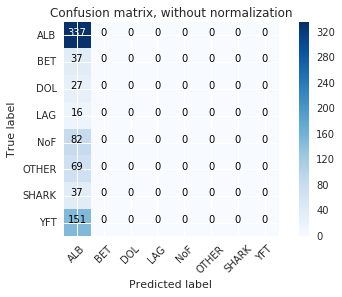

In [18]:
from sklearn.metrics import classification_report, confusion_matrix
cnf_matrix = confusion_matrix(np.argmax(y_valid,axis =1),y_pred)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=FISH_CLASSES,
                      title='Confusion matrix, without normalization')